<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v4: Weight visualisation during learning
This is a new attempt at visualising weight changes during learning, now that I have a better understanding of TensorFlow's auto-graph.

Focus of this notebook:
* generating heatmap images of gradients over time of learning.

Sample training domains:

---


* Deep Learning Specialization C2W2A1 experiments with weight initialisation, against a simple 2D binary classification problem.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

## Useful tools

In [3]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=None, display_total=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval
        self.display_total = display_total

    def set_params(self, params):
        self.epoch_count = params['epochs']
        if self.display_interval == None:
          self.display_interval = math.floor(self.epoch_count / self.display_total)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.display_interval == 0) or epoch == self.epoch_count-1:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

## Baseline: Simple model without visualisations
Actually, we're going to create a setup with few slightly different training regimes corresponding to the experiments from the coursework.


In [4]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


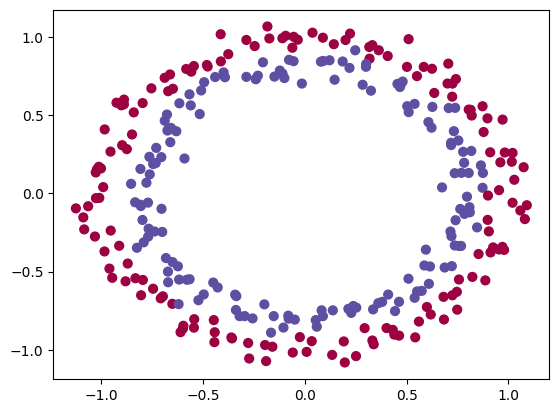

In [5]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [6]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch  1500: loss: 0.2160  
Epoch  3000: loss: 0.0713  
Epoch  4500: loss: 0.0347  
Epoch  6000: loss: 0.0191  
Epoch  7500: loss: 0.0125  
Epoch  9000: loss: 0.0094  
Epoch 10500: loss: 0.0078  
Epoch 12000: loss: 0.0070  
Epoch 13500: loss: 0.0065  
Epoch 15000: loss: 0.0063  
Total training time: 84.76 secs


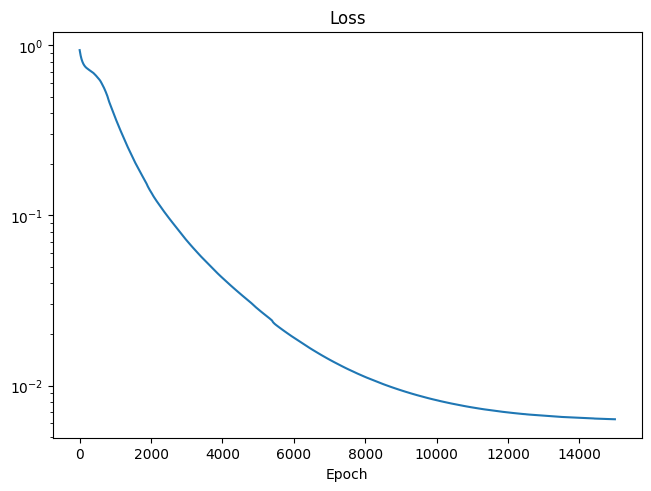

In [7]:
plot_fit(history)

## Quick Win: Weight Histogram
Let's create quick'n'dirty function for visualising the current weights, in the form of a histogram.

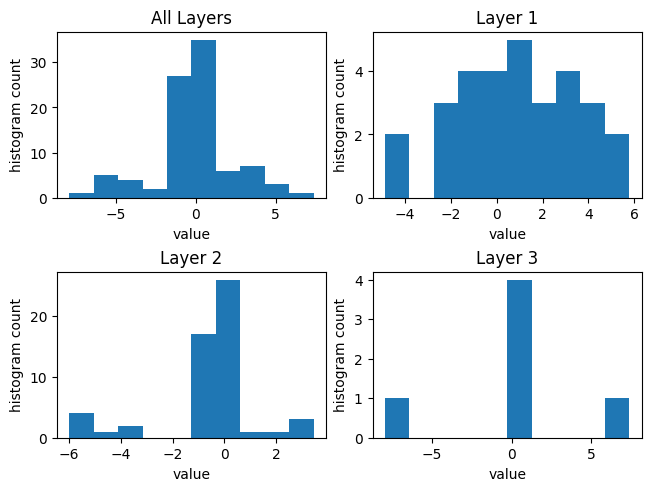

In [8]:
def plot_weights(model):
  """
  model - the model
  """

  # collect all variables across the entire model into a single flattened array
  all_variables = []
  for layer in model.layers:
    for weight in layer.weights:
      all_variables = np.append(all_variables, weight.numpy().flatten())

  L = len(model.layers)
  plots_tot = L+1
  plots_cols = math.floor(math.sqrt(plots_tot))
  plots_rows = math.ceil(plots_tot / plots_cols)

  plt.figure(layout='constrained')

  plt.subplot(plots_rows, plots_cols, 1)
  plt.title("All Layers")
  plt.hist(all_variables)
  plt.xlabel("value")
  plt.ylabel("histogram count")

  for l in range(L):
    variables = []
    for weight in model.layers[l].weights:
      variables = np.append(variables, weight.numpy().flatten())
    plt.subplot(plots_rows, plots_cols, l+2)
    plt.title(f"Layer {l+1}")
    plt.hist(variables)
    plt.xlabel("value")
    plt.ylabel("histogram count")
  plt.show()
plot_weights(model)

## Gradient heatmap
There's two things to do here:
1. Collect gradient information during training
2. Plot it in various ways.

TensorFlow doesn't seem to provide very good means for capturing gradient information during training. It's standard Logger interface doesn't get passed that information. Instead, an Optimizer-wrapper seems the only solution.

In [9]:
#v = tf.Variable()
foo= tf.TensorArray(tf.float32, size=0, dynamic_size=True)
foo = foo.write(0, 1.0)
foo = foo.write(1, 2.0)
f = foo.stack()
#f.mark_used()
f

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 2.], dtype=float32)>

In [10]:
@tf.function
def try_it2(its):
  arr = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
  for i in range(its):
    arr = arr.write(i, tf.constant(i, dtype=tf.float32))
  return arr.stack()
try_it2(3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>

In [11]:
@tf.function
def try_it2(arr, its):
  for i in range(its):
    arr = arr.write(i, tf.constant(i, dtype=tf.float32))
  return arr.stack()

arr = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
try_it2(arr, 3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>

In [12]:
@tf.function
def try_it2(arr, its):
  for i in range(its):
    arr = arr.write(i, tf.constant(i, dtype=tf.float32))

arr = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
try_it2(arr, 3)
arr.stack() # --> throws: The tensor <tf.Tensor 'Const:0' shape=() dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=try_it2, id=136881353945104), which is out of scope.

TypeError: <tf.Tensor 'Const:0' shape=() dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'Const:0' shape=() dtype=float32> was defined here:
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-12-95a96c68d30c>", line 7, in <cell line: 7>
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 832, in __call__
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 888, in _call
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 695, in _initialize
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 178, in trace_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 283, in _maybe_define_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 310, in _create_concrete_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/func_graph.py", line 1059, in func_graph_from_py_func
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 598, in wrapped_fn
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/autograph_util.py", line 41, in autograph_handler
    File "<ipython-input-12-95a96c68d30c>", line 3, in try_it2
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/operators/control_flow.py", line 449, in for_stmt
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/operators/control_flow.py", line 500, in _py_for_stmt
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/operators/control_flow.py", line 466, in protected_body
    File "<ipython-input-12-95a96c68d30c>", line 4, in try_it2
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/weak_tensor_ops.py", line 142, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py", line 271, in constant
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py", line 286, in _constant_impl
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 268, in _create_graph_constant
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/func_graph.py", line 670, in _create_op_internal
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def

The tensor <tf.Tensor 'Const:0' shape=() dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=try_it2, id=133628550997920), which is out of scope.

In [ ]:
@tf.function
def try_it3(v, its):
  for i in range(its):
    v.assign_add(i)

v = tf.Variable(0.0, dtype=tf.float32)
try_it3(v, 3)
v

In [ ]:
tf.zeros(shape=(0,0))

In [ ]:
tf.concat([tf.zeros(shape=(0,2)), tf.zeros(shape=(2,2))], axis=0)

In [ ]:
@tf.function
def try_it4(v, its):
  for i in range(its):
    grads = tf.random.normal(shape=(1,3))
    tf.print(f"grads: {grads}")
    tf.print(f"grads {grads.shape}, flattened: {tf.reshape(grads, [1,-1]).shape}")
    if v.shape[0] == 0:
      tf.print("Initialising")
      v.assign(grads)
    else:
      all = tf.concat([v, grads], axis=0)
      tf.print(f"all: {all}")
      v.assign(all)

v = tf.Variable(np.zeros((0,3)), shape=tf.TensorShape(None), dtype=tf.float32) #TensorShape(None) allows us to use different shapes over time
try_it4(v, 3)
v

In [ ]:
@tf.function
def try_it4(v, its):
  for i in range(its):
    grads = tf.random.normal(shape=(1,3))
    tf.print(f"grads: {grads}")
    tf.print(f"grads {grads.shape}, flattened: {tf.reshape(grads, [1,-1]).shape}")
    if not initd:
      tf.print("Initialising")
      initd.assign(True)
      v.assign(grads)
    else:
      all = tf.concat([v, grads], axis=0)
      tf.print(f"all: {all}")
      v.assign(all)

initd = tf.Variable(False)
v = tf.Variable(np.zeros((0,3)), shape=tf.TensorShape(None), dtype=tf.float32) #TensorShape(None) allows us to use different shapes over time
try_it4(v, 3)
v

In [ ]:
@tf.function
def try_it(tfcount, tflist):
    grads = tf.constant(3.0, dtype=tf.float32)
    idx = tflist.size()
    tflist = tflist.write(0, grads)
    tfcount.assign_add(1)

try_it_count = tf.Variable(0)
try_it_grads = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
try_it(try_it_count, try_it_grads)
print(f"count: {try_it_count}")
try_it(try_it_count, try_it_grads)
print(f"count: {try_it_count}")
try_it(try_it_count, try_it_grads)
print(f"count: {try_it_count}")
foo = try_it_grads.stack()
print(foo)

In [1]:
f = tf.Variable(np.zeros((0,0)), shape=tf.TensorShape(None), dtype=tf.float32)
print(f.shape)
f.assign(tf.constant(3.0, dtype=tf.float32))
print(f.shape)

NameError: name 'tf' is not defined

In [122]:
np.prod((2,))

2

In [13]:
tf.prod((2,))

AttributeError: module 'tensorflow' has no attribute 'prod'

In [114]:
tf.size(np.zeros((1,1)))

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [24]:
# Note the basic implementation of a delegating optimizer was provided by ChatGPT and seems to be working
class LoggingOptimizerWrapper(tf.keras.optimizers.Optimizer):
  def __init__(self, optimizer='adam', name="LoggingOptimizerWrapper", **kwargs):
    """
    Args:
      delegate: real optimizer to wrap. String (name of optimizer) or optimizer instance. See `tf.keras.optimizers`.
    """
    if isinstance(optimizer, str):
      optimizer = tf.keras.optimizers.get(optimizer)
    super(LoggingOptimizerWrapper, self).__init__(f"{name}:{optimizer.name}", **kwargs)
    self._delegate = optimizer
    #self._gradients_by_step = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    #self._count = tf.Variable(0)
    self._initialised = tf.Variable(0)
    self._gradients_by_step = tf.Variable(np.zeros((0,0)), shape=tf.TensorShape(None), dtype=tf.float32)

  def build(self, var_list):
    tf.print("build() called")
    super().build(var_list)

  def _create_slots(self, var_list):
    self._delegate._create_slots(var_list)

  def _create_hypers(self):
    self._delegate._create_hypers()

  def _prepare_local(self, var_device, var_dtype, apply_state):
    return self._delegate._prepare_local(var_device, var_dtype, apply_state)

  def _init_logging(self, grads):
    # determine total number of variables across all items in grads list
    #  - tf.size(grad) returns: Tensor("cond/Size_1:0", shape=(), dtype=int32) without the actual value
    tf.print("in _init_logging")
    # tot = tf.constant(0)
    # for grad in grads:
    #   s = tf.reshape(grad, [1, -1]).shape[1]
    #   tf.print(f"grad: {grad.shape}, tf.shape: {tf.shape(grad)}, size: {s}")
    #   tot += s
    # # construct empty matrix of correct shape
    # tf.print(f"Initialising: (0,{tot}), with tot: {type(tot)}")
    # self._initialised.assign(1)
    # self._gradients_by_step.assign(np.zeros((0,tot)))
    all = tf.zeros(shape=(1,0))
    for grad in grads:
      flattened = tf.reshape(grad, [1, -1])
      #tf.print(f"flattened(init): {flattened.shape}")
      all = tf.concat([all, flattened], axis=1)
    self._initialised.assign(1)
    self._gradients_by_step.assign(all)
    # NOTE: results in the first gradients getting copied in twice, but will do for now.

  def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    """
      Args:
        grads_and_vars: List of `(gradient, variable)` pairs.
    """
    grads_and_vars = list(grads_and_vars)
    grads, trainable_variables = zip(*grads_and_vars)
    #tf.print(f"Looping: _gradients_by_step={self._gradients_by_step.shape}")
    tf.cond(self._initialised < 1, lambda: self._init_logging(grads), lambda: None)
    #for grad, var in grads_and_vars:
    #  self._init_logging(grads)

    # concatenate all gradient tuples into a single vector
    all = tf.zeros(shape=(1,0))
    for grad in grads:
      flattened = tf.reshape(grad, [1, -1])
      #tf.print(f"flattened: {flattened.shape}")
      all = tf.concat([all, flattened], axis=1)
    #tf.print(f"all: {all.shape}")

    # append to list
    self._gradients_by_step.assign(tf.concat([self._gradients_by_step, all], axis=0))
    #tf.print(f"gradients_by_step: {self._gradients_by_step.shape}")

    #grads = tf.constant(3.);
    #idx = self._gradients_by_step.size()
    #tf.print(f"current size: {idx}")
    #self._gradients_by_step = self._gradients_by_step.write(idx, grads)
    #self._count.assign_add(1)
    # for grad in grads:
    #   tf.print(f"  grad: {type(grad)}")
    return self._delegate.apply_gradients(grads_and_vars, name, experimental_aggregate_gradients)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    return self._delegate._resource_apply_dense(grad, var, apply_state)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    return self._delegate._resource_apply_sparse(grad, var, indices, apply_state)

  def get_config(self):
    base_config = super(LoggingOptimizerWrapper, self).get_config()
    return {**base_config, "_delegate": tf.keras.optimizers.serialize(self._delegate)}

  @classmethod
  def from_config(cls, config, custom_objects=None):
    delegate_config = config.pop('_delegate')
    delegate = tf.keras.optimizers.deserialize(delegate_config, custom_objects=custom_objects)
    return cls(delegate, **config)

  def _serialize_hyperparameter(self, hyperparameter):
    return self._delegate._serialize_hyperparameter(hyperparameter)

  def get_updates(self, loss, params):
    return self._delegate.get_updates(loss, params)

  def get_weights(self):
    return self._delegate.get_weights()

  def set_weights(self, weights):
    self._delegate.set_weights(weights)

  def variables(self):
    return self._delegate.variables()

  def get_slot(self, var, name):
    return self._delegate.get_slot(var, name)

  def get_slot_names(self):
    return self._delegate.get_slot_names()

model = binary_classification_model('he_normal')
#model.compile(optimizer=LoggingOptimizerWrapper(tf.keras.optimizers.Adam()), loss='binary_crossentropy')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=4, batch_size=train_X.shape[0])
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")

Epoch 1/4
in _init_logging
1/1 [==============================] - 1s 1s/step - loss: 0.7317
Epoch 2/4
1/1 [==============================] - 0s 12ms/step - loss: 0.7309
Epoch 3/4
1/1 [==============================] - 0s 12ms/step - loss: 0.7302
Epoch 4/4
1/1 [==============================] - 0s 11ms/step - loss: 0.7294
gradient_history: (5, 91)


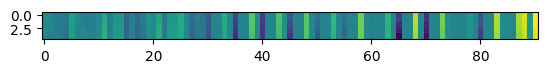

In [22]:
plt.imshow(gradient_history)

In [29]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=5000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")

in _init_logging
Epoch   500: loss: 0.6458  
Epoch  1000: loss: 0.2211  
Epoch  1500: loss: 0.0819  
Epoch  2000: loss: 0.0539  
Epoch  2500: loss: 0.0404  
Epoch  3000: loss: 0.0321  
Epoch  3500: loss: 0.0255  
Epoch  4000: loss: 0.0159  
Epoch  4500: loss: 0.0121  
Epoch  5000: loss: 0.0101  
gradient_history: (5001, 91)
Total training time: 22.39 secs


Exception ignored in: <function _xla_gc_callback at 0x7988fa8d1d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


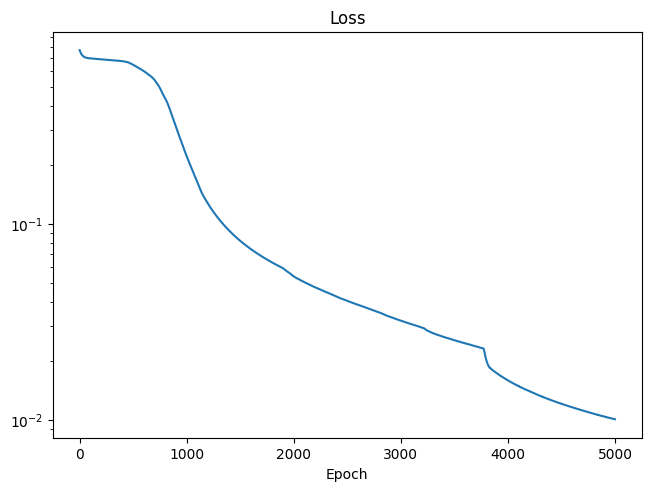

In [30]:
plot_fit(history)

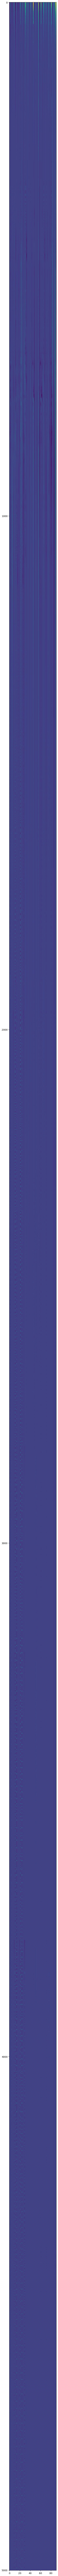

In [41]:
plt.figure(figsize = (500,200))
plt.imshow(gradient_history)